[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PennNGG/Quantitative-Neuroscience/blob/master/Probability%20Distributions/Python/Exponential.ipynb)

# Definition

The exponential distribution describes the distribution of times between discrete events that are generated by a memoryless process; i.e., a Poisson point process. It is a special case of a gamma distribution.

Note that the exponential distribution is not the same as the exponential family of distributions, which includes the exponential distribution but also the normal, binomial, gamma, Poisson, and other distributions.

Mathematically, the probability density function of an exponential distribution is:

$f(x; \lambda) = \lambda e^{-\lambda x}$ when *x*≥0, 0 otherwise.

# Ruminations on Randomness

The Exponential distribution provides a good opportunity to look more deeply at the concept of "random." Consider what many think of as the default concept of random, as exemplified by the function [rand](https://www.mathworks.com/help/matlab/ref/rand.html) in Matlab: a pick from a uniform distribution, in this case a double-precision floating-point value in the interval (0,1). That is, pick a number, any number, between 0 and 1. Random, right? (Well, except for [this](https://en.wikipedia.org/wiki/Pseudorandom_number_generator).)

Now consider a particular context in which you might want to produce intervals of a truly random length; say, the time of occurrence of the next instance of some event to be totally unpredictable (e.g., [the use of a random foreperiod to avoid expectations in a psychophysical task](https://link.springer.com/article/10.3758/BF03202946)). Just use a function like rand() to pick a random number from a uniform distribution on each trial, right? Wrong!

One way to think about this is from the perspective of the subject performing the task. Let's say the random foreperiod is picked from a uniform distribution between 1 and 5 seconds (i.e., the experimental stimulus will be shown 1–5 seconds after the start of the trial). After enough trials, the subject will likely figure out that the foreperiod will last 1–2 seconds ~20% of the time, 2–3 seconds ~20% of the time, and so on. But that's considering the duration before the trial starts. Now consider the perspective from within the trial. In this case, think of the short interval of time just after the foreperiod starts and a similar interval of time just before the foreperiod ends. In the case of the former, it is not particularly likely that the foreperiod will end then, because all of the equal-sized intervals that follow have the same probability of the end occurring. However, in the case of the latter, the subject knows darned well that it will end then -- if you make it to the end of the foreperiod, then it is guaranteed to end then.

The key, of course, is that when you are in the middle of the foreperiod on a given trial, you have more information than you had before the trial started; specifically, the fact that foreperiod has not ended yet. A truly random process has the same "knowledge": the probability of an event occurring for the first time after a certain amount of time necessarily requires that it hadn't happened yet. 

# Getting Started with Code


Matlab code is found in the [NGG Statistics GitHub Repository](https://github.com/PennNGG/Statistics.git) under "Probability Distributions/Exponential.m".

Python code is included below. First run the code cell just below to make sure all of the required Python modules are loaded, then you can run the other cell(s).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import binom
from scipy.stats import expon


# Tutorial

number of events expected=1000, actual=971


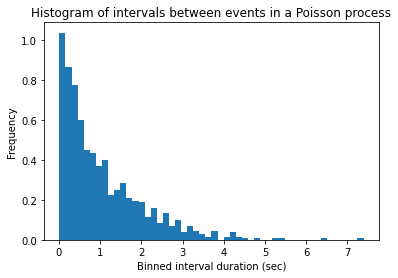

In [2]:
# Let's go back to simulating a Poisson process as the limit of a sequence of 
# Bernoulli trials as the interval size->0. 
delta_t = 1000          # Assume the whole process takes this long
plambda = 1             # Rate (events per sec)
num_bins_per_second = 100    # Number of bins in which to check for events
total_bins = round(num_bins_per_second*delta_t)

# First convert lambda (overall rate) to probability/bin, using deltaT 
#   events/time divided by bins/time = events/bin
p = plambda * delta_t / total_bins

# Now simulate checking one "outcome" per bin, using the given probability/bin
outcomes = binom.rvs(1, p, size=total_bins)

# Check that the nubmer of events is what we expect
print(f'number of events expected={plambda*delta_t}, actual={np.sum(outcomes==1)}')

# Now for the next part -- instead of looking at the counts per interval, 
#   which is what the Poisson distribution described, we are now going to look 
#   at the same data but are considering the intervals between events. As you 
#   will see below, these intervals are distributed as an exponential.
# First look at the histogram of intervals between events
# Get intervals
intervals_between_events = np.diff(np.where(outcomes==1))

# Convert to seconds
intervals_between_events_sec = intervals_between_events/num_bins_per_second

# Make and show the normalized histogram. Here the interval is a continuous 
#   variable (the x-axis is binned in the histogram to visualize it, but the 
#   actual values can take on any continuous value because they represent the 
#   amount of time since the previous event), so to normalize the histogram to 
#   make a pdf we can't just sum the values -- we have to sum the values 
#   multiplied by the bin width (i.e., take the integral). We use numpy's 
#   "trapz" which treats each bin as a trapezoid (because the heights before 
#   and after can be slightly different) to compute the integral:
counts, edges = np.histogram(intervals_between_events_sec, bins=50)
plt.bar(edges[:-1], np.divide(counts, np.trapz(counts, edges[:-1])), width=0.15, align='edge')
plt.title('Histogram of intervals between events in a Poisson process')
plt.xlabel('Binned interval duration (sec)')
plt.ylabel('Frequency')

# Compare to an exponential distribution (see below), in red, with the rate 
#   parameter lambda equal to 1/lambda
# plt.plot(edges[:-1], expon.pdf(edges[:-1], scale=1/plambda), 'r-', linewidth=2)
plt.show()

lambda*deltaT = 4754.85, mean = 4754.68,   var = 4956.00


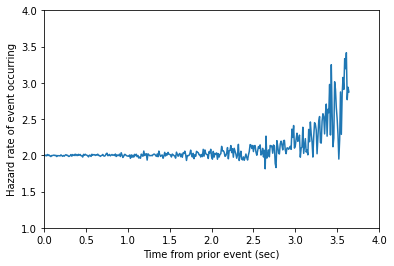

In [5]:
# Here's a better way to simulate a Poisson process: instead of 
#   approximating continuous time with small time bins, directly simulate 
#   the (continuous) time between events as an exponential
plambda = 2                     # events/sec
events_per_simulation = 5000    # events/simulation
num_simulations = 1000          # number of simulations

# The mean of the (exponential) distribution of intervals between events 
#   generated by a Poisson process is equal to the inverse of the rate at 
#   which the events are generated (because time/event is the inverse of events/time)
mu = 1/plambda

# Simulate a bunch of intervals picked from an exponential distribution 
#   (using numpy's version here, which is supposed to be faster than scipy) - 
#   rows are events, coluns are simulations
intervals = np.random.exponential(mu, size=(events_per_simulation, num_simulations))

# Sum them per run (columns) so the events correspond to timestamps
times = np.cumsum(intervals, axis=0)

# A bit of a cheat -- find the run with the shortest time, then use that as 
#   the interval to test across runs
min_time = min(times[-1])

# Count the times less than the min interval per run
counts = sum(times<=min_time)

# Check mean, var (for a simulated Posson process, the mean and var should be 
# pretty close to each other -- where "pretty close" is going to depend on 
# factors like N and M)
print(f'lambda*deltaT = {plambda*min_time:.2f}, mean = {np.mean(counts):.2f}, \
  var = {np.var(counts):.2f}')

# Now let's consider the "Randomness" of this process in more detail.
#   We say that it has a "flat hazard function": at any given point in time 
#   there is an equal probabilty of the event occuring, given that it hasn't 
#   occurred yet. We can compute this function from the simulated intervals as 
#   the pdf/(1-cdf) [that is, the probability of a given interval, defined as 
#   the pdf, divided by 1 - the probablity that the given interval occurred]:

# Compute over this range. See below for an explanation of what the upper range 
#   (here scaled by rangeScale) does to the calcluation.
rangeScale = 10
xs = np.arange(0, mu*rangeScale+0.01, 0.01)

# Compute separately per simulation, will store in this matrix
hazards = np.zeros((np.size(xs)-1, num_simulations))

# Loop through the simulations
for ii in range(1, num_simulations):

    # Get the histogram of intervals using bins defined by "xs"
    counts, edges = np.histogram(intervals[intervals[:,ii]<min_time, ii], bins=xs)

    # Convert into a pdf
    i_pdf = np.divide(counts, np.trapz(counts, xs[:-1]))

    # Compute the cdf, again using trapz
    i_cdf = scipy.integrate.cumtrapz(i_pdf, xs[:-1], initial=0)
    i_cdf[i_cdf==1] = np.nan # avoid div by zero

    # Save the hazard
    hazards[:, ii] = np.divide(i_pdf, 1-i_cdf)

# Show the mean hazard across runs. Notice that:
#
# 1. it is roughly constant and equal to 2 --- which is the rate (lambda) that 
#     we started with above (and the inverse of the mean of the exponential 
#     distribution of intervals that we generated).
#
# 2. The mean is noisy, especially for long intervals (large values along the 
#     x-axis) - this is because those intervals don't happen very much (the 
#     long tail of the exponential distribution) so even with large N those 
#     points are undesampled.
#
# 3. For very large intervals, the results are not just noisy, but biased 
#     (the hazard rate starts to sweep upwards on the right of the figure). 
#     This is because the true exponential has a tail that goes to infinity, 
#     but here we stop it at some finite time. This procedure implies that 
#     events that in a real Poisson process (with a real flat hazard) would 
#     occur after a very long interval will be counted here as bunching up in 
#     the longest bins we check -- so the probability of occurrance in those 
#     bins will be slighly higher than expected for a real exponential, making 
#     the hazard rate larger, too. You can make this effect more pronounced by 
#     choosing a shorter range of xs, above.
plt.plot(xs[:-1], np.mean(hazards,axis=1))
plt.xlabel('Time from prior event (sec)')
plt.ylabel('Hazard rate of event occurring')
plt.axis([0, 4, 1, 4])
plt.show()

I will recreate this plot of the pdf of the quantal interrelease interval at a mammalian rod synpase from [this paper](https://www.academia.edu/49672849/Rate_of_quantal_transmitter_release_at_the_mammalian_rod_synapse). According to the text, only 16% of release events are separated by 50ms or more, so I will test that number by simulating draws from an exponential with the parameters reported in the paper.

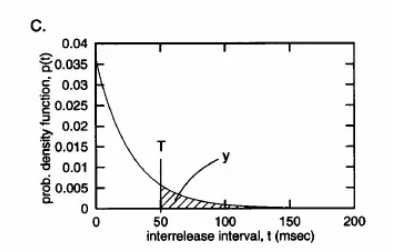

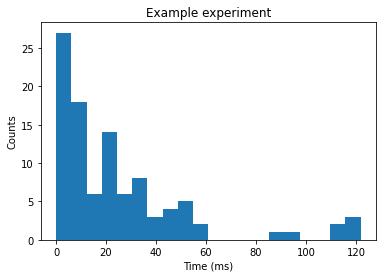

In [17]:
# say we do 10 experiments with 100 trials each
Ntrials = 100
Nexps = 10
quanta_per_msec = 37/1000
msec_per_quanta = 1/quanta_per_msec
intervals = np.random.exponential(msec_per_quanta, size=(Ntrials,Nexps))

# plot one example experiment
fig, ax = plt.subplots(1,1)
ax.hist(intervals[:,0],bins=20)
ax.set_title('Example experiment')
ax.set_ylabel('Counts')
ax.set_xlabel('Time (ms)')
plt.show()

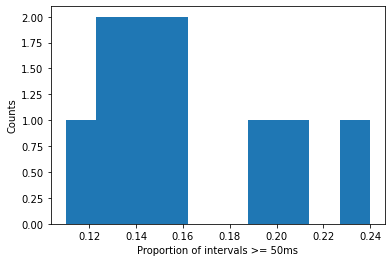

In [18]:
# compute proportion of intervals >= 50ms for each experiment and plot
int50 = np.mean(intervals >= 50,axis=0)
fig, ax = plt.subplots(1,1)
ax.hist(int50)
ax.set_ylabel('Counts')
ax.set_xlabel('Proportion of intervals >= 50ms')
plt.show()

# Additional Resources

Working with the exponential distribution in [Matlab](https://www.mathworks.com/help/stats/exponential-distribution.html), [R](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/Exponential), and [Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html).

# Credits

Copyright 2021 by Joshua I. Gold, University of Pennsylvania